<a href="https://colab.research.google.com/github/Rosha2020/IIC3633/blob/master/Copy_of_Implicit_implicit_feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctico librería implicit - ALS y BPR

Clase: IIC3633 Sistemas Recomendadores, PUC Chile

En este práctico vamos a utilizar la biblioteca de Python [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) para recomendación utilizando ALS y BPR. 

In this lab we are going to use the Python implicit library for recommendation using ALS and BPR.

In [162]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    618      0 --:--:-- --:--:-- --:--:--   617
100 1546k  100 1546k    0     0  2035k      0 --:--:-- --:--:-- --:--:-- 2035k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1175      0 --:--:-- --:--:-- --:--:--  1175
100  385k  100  385k    0     0   848k      0 --:--:-- --:--:-- --:--:--  848k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1201      0 --:--:-- --:--:-- --:--:--  1197
100  230k  100  230k    0     0   523k      0 --:--:-- --:--:-- --:--:--  523k


In [163]:
!pip3 install implicit --upgrade

Requirement already up-to-date: implicit in /usr/local/lib/python3.6/dist-packages (0.4.4)


In [164]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse
import matplotlib.pyplot as plt

In [165]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [166]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [167]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [168]:
# Cargamos el dataset con los items We load the dataset with the items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [169]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [170]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [171]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


### Métricas

In [172]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239
# Definition of metrics (Do not edit)
# Obtained from

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

Preprocessing the data to sparse format

In [173]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [174]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [175]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [176]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

Briefly explain how the ALS algorithm works.

**Respuesta:**  
The alternating least squares (ALS) algorithm factorizes a given matrix R into two factors U and V such that R≈UTV. The unknown row dimension is given as a parameter to the algorithm and is called latent factors. Since matrix factorization can be used in the context of recommendation, the matrices U and V can be called user and item matrix, respectively. The ith column of the user matrix is denoted by ui and the ith column of the item matrix is vi. The matrix R can be called the ratings matrix with (R)i,j=ri,j.

In [177]:
# Definimos y entrenamos el modelo con optimización ALS, We define and train the model with ALS optimization
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

Example of recommendation and search for similar items with the latent factors already trained:

In [178]:
show_recommendations(model_als, user=77, n=10)

movieid
258                                        Contact (1997)
409                                           Jack (1996)
256     When the Cats Away (Chacun cherche son chat) (...
292                                       Rosewood (1997)
754                                     Red Corner (1997)
1012                                 Private Parts (1997)
285                                 Secrets & Lies (1996)
248                            Grosse Pointe Blank (1997)
257                                   Men in Black (1997)
242                                          Kolya (1996)
Name: title, dtype: object

In [179]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.05896647533656881
ndcg: 0.33690658499234305


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

Try different values for the ALS parameters and display graphs of how the newly displayed metrics are affected.

In [180]:
model_als = implicit.als.AlternatingLeastSquares(factors=200, iterations=10, use_gpu=False)
model_als.fit(matrix)

In [181]:
show_recommendations(model_als, user=77, n=10)

movieid
754                Red Corner (1997)
292                  Rosewood (1997)
239                  Sneakers (1992)
300             Air Force One (1997)
125                Phenomenon (1996)
327                  Cop Land (1997)
121    Independence Day (ID4) (1996)
676             Crucible, The (1996)
460       Crossing Guard, The (1995)
368                  Bio-Dome (1996)
Name: title, dtype: object

In [182]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.0481563521024488
ndcg: 0.31393568147013784


---

In [202]:
factor_values = [32, 64, 96]
als_maps = []
als_ndcgs = []
for f in factor_values:
  model_als = implicit.als.AlternatingLeastSquares(factors=f, iterations=10, use_gpu=False)
  model_als.fit(matrix)
  maprec, ndcg = evaluate_model(model_als, n=20)
  print('{} factores \nmap: {}\nndcg: {}\n'.format(f, maprec, ndcg))
  als_maps.append(maprec)
  als_ndcgs.append(ndcg)


32 factores 
map: 0.10713317680501978
ndcg: 0.4992343032159265




64 factores 
map: 0.10833386287369717
ndcg: 0.49770290964777947




96 factores 
map: 0.11486573599834746
ndcg: 0.5206738131699847



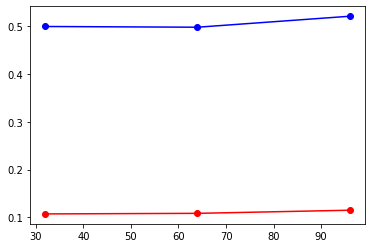

In [203]:
plt.plot(factor_values, als_maps, 'ro-')
plt.plot(factor_values, als_ndcgs, 'bo-')
plt.show()

## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.

Explain in your words the intuition of the BPR framework.

its goal is  to find a custom ranking function. BPR by itself is not an algorithm, rather a loss function and a framework to carry out optimization.
Bayesian Personalized Ranking optimization criterion involves pairs of items(the user-specific order of two items) to come up with more personalized rankings for each user.



In [183]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores 
latentes ya entrenados:

Example of recommendation and search for similar items with the latent factors already trained:

In [184]:
show_recommendations(model_bpr, user=77, n=10)

movieid
257                               Men in Black (1997)
299                                    Hoodlum (1997)
327                                   Cop Land (1997)
267                                           unknown
285                             Secrets & Lies (1996)
312    Midnight in the Garden of Good and Evil (1997)
301                                   In & Out (1997)
746                                Real Genius (1985)
332                             Kiss the Girls (1997)
306       Mrs. Brown (Her Majesty, Mrs. Brown) (1997)
Name: title, dtype: object

In [185]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171                Delicatessen (1991)
209          This Is Spinal Tap (1984)
203                  Unforgiven (1992)
172    Empire Strikes Back, The (1980)
27                     Bad Boys (1995)
78                   Free Willy (1993)
201                Evil Dead II (1987)
68                    Crow, The (1994)
175                      Brazil (1985)
264                       Mimic (1997)
Name: title, dtype: object

In [186]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.050547892455922984
ndcg: 0.33996937212863704


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas de ranking (nDCG@10 y MAP) recién mostradas.

Try different values for the BPR parameters and display graphs of how the ranking metrics (nDCG @ 10 and MAP) just displayed are affected.

In [187]:
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=300, iterations=30, use_gpu=False)
model_bpr.fit(matrix)

In [188]:
show_recommendations(model_bpr, user=77, n=10)

movieid
257                       Men in Black (1997)
285                     Secrets & Lies (1996)
299                            Hoodlum (1997)
327                           Cop Land (1997)
244             Smilla's Sense of Snow (1997)
301                           In & Out (1997)
99     Snow White and the Seven Dwarfs (1937)
332                     Kiss the Girls (1997)
267                                   unknown
49                                I.Q. (1994)
Name: title, dtype: object

In [189]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171                Delicatessen (1991)
27                     Bad Boys (1995)
172    Empire Strikes Back, The (1980)
203                  Unforgiven (1992)
68                    Crow, The (1994)
78                   Free Willy (1993)
209          This Is Spinal Tap (1984)
194                  Sting, The (1973)
201                Evil Dead II (1987)
3                    Four Rooms (1995)
Name: title, dtype: object

In [190]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.048221561006501344
ndcg: 0.33843797856049007


In [205]:
factor_values = [32, 64, 96]
bpr_maps = []
bpr_ndcgs = []
#for f in factor_values:
# model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f, iterations=30, use_gpu=True, use_cg=True, random_state = 11)
# model_bpr.fit(matrix)
for f in factor_values:
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=300, iterations=30, use_gpu=False)
  model_bpr.fit(matrix)
  maprec, ndcg = evaluate_model(model_bpr, n=10)
  print('{} factores \nmap: {}\nndcg: {}\n'.format(f, maprec, ndcg))
  bpr_maps.append(maprec)
  bpr_ndcgs.append(ndcg)


32 factores 
map: 0.05372478175932226
ndcg: 0.35222052067381315




64 factores 
map: 0.05444500347027166
ndcg: 0.3675344563552833




96 factores 
map: 0.05672446788576619
ndcg: 0.3445635528330781



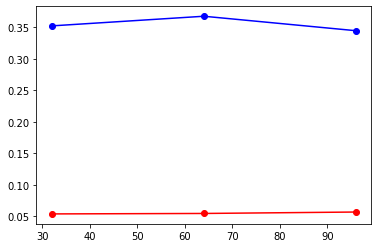

In [206]:
plt.plot(factor_values , bpr_maps, 'ro-')
plt.plot(factor_values, bpr_ndcgs, 'bo-')
plt.show()